In [1]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from copy import deepcopy
import time
import matplotlib.pyplot as plt
import random
from datetime import datetime
import tensorflow as tf
import tensorflow.keras as K
import numpy as np

In [2]:
from src.data.make_dataset import make_dataset
from src.data.dataset_loaders import AerialCarsDatasetLoader
from src.data.image_loaders import AerialCarsFixedSizeImageLoader
from src.features.pipelines import RawImageToImage
from src.features.processors import NormImage
from src.features.descriptors import HOGDescriptor, LBPDescriptor
from src.models.detectors import SliderDetector, NNSliderDetector
from src.data.sliders import SlidingWindow

In [3]:
BND_BOX_SIZE = (128, 128)
SLIDER_STEP_SIZE = 16
DATASET_PATH = '../../data/raw/aerial-cars-dataset/'
VAL_DATASET_PATH = '../../data/raw/aerial-cars-dataset/val/'
WORKERS = 0

In [4]:
dataset_loader = AerialCarsDatasetLoader(
    image_loader=AerialCarsFixedSizeImageLoader(
        bnd_box_size=BND_BOX_SIZE
    )
)

process_pipeline=RawImageToImage(
    processors=[
        NormImage()
    ]
)

## Features dataset

In [5]:
start_time = time.time()

data = make_dataset(
    input_folder_filepath=DATASET_PATH,
    output_filepath='output_path',
    dataset_loader=dataset_loader,
    images_files_types=('jpg', 'JPG', 'png'),
    annotations_files_types=('txt',),
    process_pipeline=process_pipeline,
    negative_images_size=BND_BOX_SIZE,
    negative_examples_size=0.3,
    workers=WORKERS,
    verbose=True
)

print()
print("--- %s seconds ---" % (time.time() - start_time))

100%|██████████| 1153/1153 [00:00<00:00, 3720.07it/s]
--- 2.389068603515625 seconds ---



## ResNet training

In [6]:
X = np.array(list(map(lambda x: x[1], data)))
y = np.array(list(map(lambda x: x[2], data)))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [7]:
input_t = K.Input(shape=(X[0].shape))
res_model = K.applications.ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_tensor=input_t
)

In [8]:
for layer in res_model.layers:
    layer.trainable = False

In [9]:
model = K.models.Sequential()
model.add(res_model)
model.add(K.layers.Flatten())
model.add(K.layers.Dense(2, activation='softmax'))

In [10]:
model.compile(optimizer=K.optimizers.Adam(0.01),
            loss=K.losses.SparseCategoricalCrossentropy(),
            metrics=['accuracy']
)

history = model.fit(X_train, y_train,
            batch_size=100,
            epochs=1, 
            validation_data=(X_test, y_test)
)

11/11 [==============================] - 18s 2s/step - loss: 6.8651 - accuracy: 0.8852 - val_loss: 4.4094 - val_accuracy: 0.9483


## Test images loading

In [11]:
images = dataset_loader.load_dataset(
    input_folder_filepath=VAL_DATASET_PATH,
    images_files_types=('jpg', 'JPG', 'png'),
    annotations_files_types=('txt',),
    verbose=True
)

100%|██████████| 6/6 [00:00<00:00, 67.32it/s]


In [12]:
len(images)

3

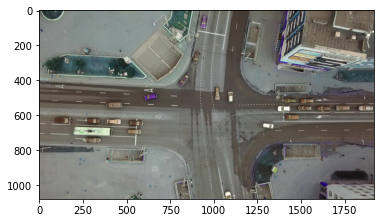

In [13]:
plt.imshow(images[0].image)

## Sliding detection

In [14]:
sliding_window = SlidingWindow(
    step_size=SLIDER_STEP_SIZE,
    window_size=BND_BOX_SIZE
)

In [15]:
class ModelWrapper:

    def __init__(self, model):
        self.model = model

    def predict(self, x):
        return np.argmax(self.model.predict(np.array([x])))

In [16]:
slider_detector = SliderDetector(
    sliding_window=sliding_window,
    process_pipeline=process_pipeline,
    classifier=ModelWrapper(model)
)

### Non-parallel approach

In [17]:
start_time = time.time()

(image, bnd_boxes) = slider_detector(deepcopy(images[1]), WORKERS, True)

print()
print("--- %s seconds ---" % (time.time() - start_time))

6569it [07:47, 14.06it/s]


KeyboardInterrupt: 

In [36]:
len(bnd_boxes)

104

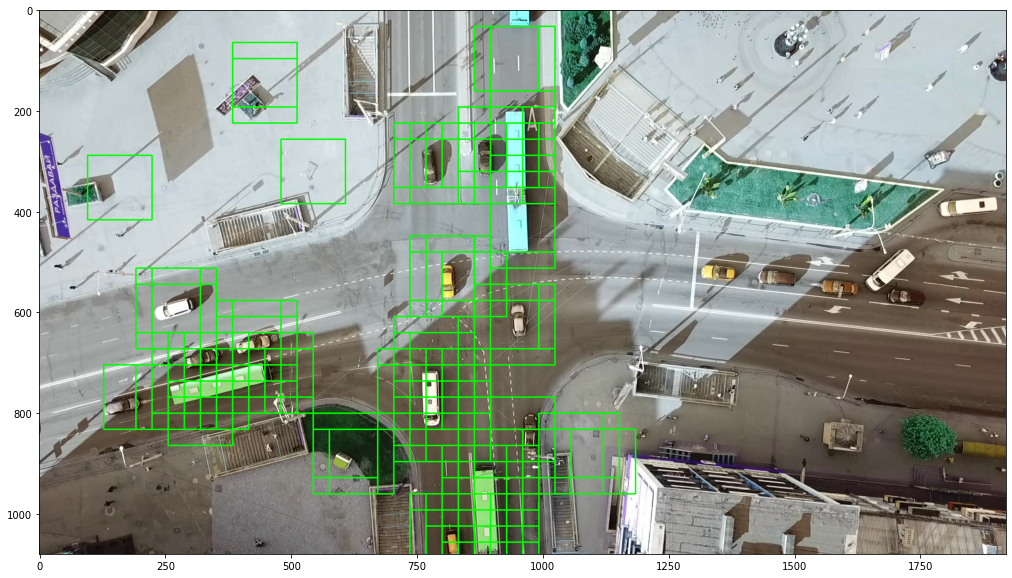

In [38]:
plt.figure(figsize=(20,10))
plt.imshow(image)
plt.savefig('./2-4-detection-'+datetime.now().strftime("%d_%m_%Y_%H_%M_%S")+'.jpg')

## NN Sliding detection

In [18]:
sliding_window = SlidingWindow(
    step_size=SLIDER_STEP_SIZE,
    window_size=BND_BOX_SIZE
)

In [19]:
class ModelWrapper:

    def __init__(self, model):
        self.model = model

    def predict(self, images):
        results = []
        batches = np.array_split(images, round(len(images)/200))
        for batch in batches:
            batch = np.stack(batch, 0)
            print(batch.shape)
            preds = self.model.predict(batch)
            for pred in preds:
                results.append(np.argmax(pred))
        return results

In [20]:
slider_detector = NNSliderDetector(
    sliding_window=sliding_window,
    process_pipeline=process_pipeline,
    classifier=ModelWrapper(model)
)

In [21]:
start_time = time.time()

(image, bnd_boxes) = slider_detector(deepcopy(images[1]), WORKERS, True)

print()
print("--- %s seconds ---" % (time.time() - start_time))

(200, 128, 128, 3)
(199, 128, 128, 3)
(199, 128, 128, 3)
(199, 128, 128, 3)
(199, 128, 128, 3)
(199, 128, 128, 3)
(199, 128, 128, 3)
(199, 128, 128, 3)
(199, 128, 128, 3)
(199, 128, 128, 3)
(199, 128, 128, 3)
(199, 128, 128, 3)
(199, 128, 128, 3)
(199, 128, 128, 3)
(199, 128, 128, 3)
(199, 128, 128, 3)
(199, 128, 128, 3)
(199, 128, 128, 3)
(199, 128, 128, 3)
(199, 128, 128, 3)
(199, 128, 128, 3)
(199, 128, 128, 3)
(199, 128, 128, 3)
(199, 128, 128, 3)
(199, 128, 128, 3)
(199, 128, 128, 3)
(199, 128, 128, 3)
(199, 128, 128, 3)
(199, 128, 128, 3)
(199, 128, 128, 3)
(199, 128, 128, 3)
(199, 128, 128, 3)
(199, 128, 128, 3)
(199, 128, 128, 3)
(199, 128, 128, 3)
(199, 128, 128, 3)
(199, 128, 128, 3)
(199, 128, 128, 3)
(199, 128, 128, 3)
(199, 128, 128, 3)
(199, 128, 128, 3)

--- 180.5168972015381 seconds ---


In [22]:
len(bnd_boxes)

100

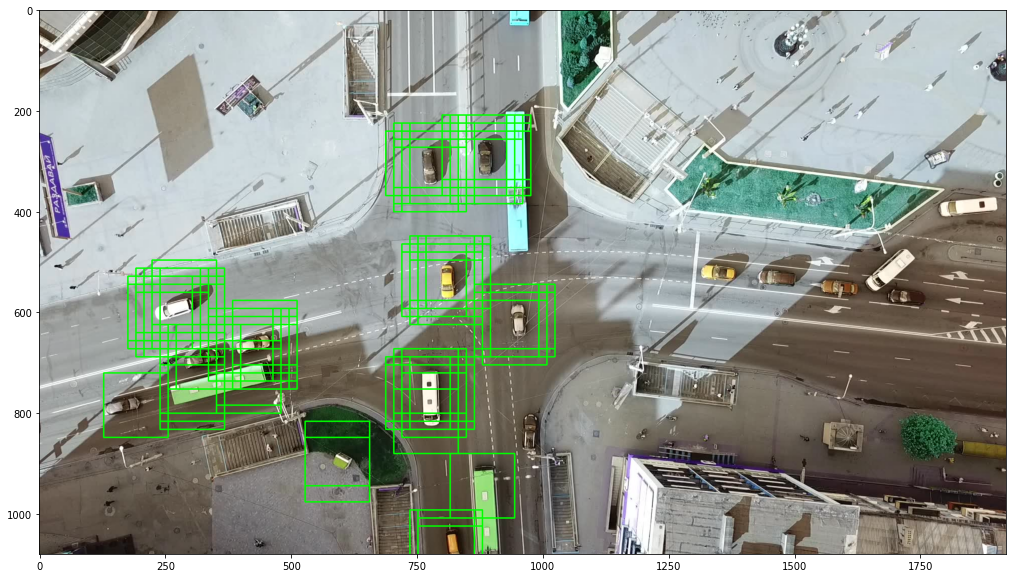

In [23]:
plt.figure(figsize=(20,10))
plt.imshow(image)
plt.savefig('./2-4-detection-'+datetime.now().strftime("%d_%m_%Y_%H_%M_%S")+'.jpg')